# Install Libraries

In [1]:
# !pip install tensorflow pandas numpy sklearn
# !pip install pandas scikit-learn
# !pip install lime shap

# Import Libraries

In [2]:
import itertools
import random
from datetime import timedelta

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, LSTM, SimpleRNN
from tensorflow.keras.metrics import AUC, FalseNegatives, FalsePositives, Precision, TrueNegatives, TruePositives
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Extract Raw Data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
file_path_AU_raw = '/content/drive/MyDrive/CKD/GitHub/data/raw/AU/eGFR 12-09-2023.xlsx'
file_path_JP_raw = '/content/drive/MyDrive/CKD/GitHub/data/raw/JP/ROUTE_proteinuria_dataset.xlsx'

In [5]:
file_path_AU_raw = '/content/drive/MyDrive/CKD/Data/Raw/AU Raw/eGFR 12-09-2023.xlsx'
file_path_JP_raw = '/content/drive/MyDrive/CKD/Data/Raw/JP Raw/ROUTE_proteinuria_dataset.xlsx'

# Preprocess Australian (AU) Data

## 1) Applying Inclusion Criteria

In [6]:
df = pd.read_excel(file_path_AU_raw)

In [7]:
df.isna().sum()

COLLECTED               0
ID                      0
SEX                     0
AGE                     0
INPATIENT/OUTPATIENT    0
eGFR                    0
dtype: int64

In [8]:
df.dtypes

COLLECTED               datetime64[ns]
ID                               int64
SEX                             object
AGE                              int64
INPATIENT/OUTPATIENT            object
eGFR                            object
dtype: object

In [9]:
# Replace '> 90' with 91 and convert to integer
print(set(df['eGFR']))
df['eGFR'] = np.where(df['eGFR'].str.strip() == "> 90", 91, df['eGFR']).astype(int)
print("Total number of unique ids:", len(df['ID'].unique()))

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, '> 90   '}
Total number of unique ids: 149491


In [10]:
# Filter in Age 18 and over
df = df[df['AGE'] >= 18]
print("Total number of unique ids:", len(df['ID'].unique()))

Total number of unique ids: 149491


In [11]:
# Sort by date
df.sort_values('COLLECTED', inplace=True)

In [12]:
# Filter out patients with less than 3 eGFR measurements
df = df[df.groupby('ID').ID.transform('count') > 2]
print("Total number of unique ids:", len(df['ID'].unique()))

Total number of unique ids: 56632


In [13]:
# Filter to only include first readings between 15 (patient in a dialysis) and 59
filter_1 = df.groupby('ID')['eGFR'].apply(lambda x: 15 <= x.iloc[0] <= 59) #logic is same as (first value >=15) and (first value <=59)
df = df[df['ID'].map(filter_1)] # Applying filter
print("Total number of unique ids:", len(df['ID'].unique()))

grouped = df.groupby('ID')['eGFR'].first()
print(grouped)

Total number of unique ids: 10072
ID
2         23
7         53
10        54
14        48
19        29
          ..
149209    36
149248    46
149264    57
149302    53
149311    55
Name: eGFR, Length: 10072, dtype: int64


In [14]:
# Patients who had two eGFR readings on the same day after their first eGFR reading < 15 were considered to be on dialysis and excluded

# Group the data by 'ID' and get the date when the first eGFR < 15 for each patient
first_low_egfr_date = df[df['eGFR'] < 15].groupby('ID')['COLLECTED'].min()

# Join the dates of first low eGFR readings to the original DataFrame
df = df.join(first_low_egfr_date.rename('first_low_egfr_date'), on='ID')

# Only keep rows where 'Date' is after the 'first_low_egfr_date'
df_after_first_low_egfr = df[df['COLLECTED'] > df['first_low_egfr_date']]

# Identify patients who have 2 or more readings on any day after their first eGFR reading < 15
patients_on_dialysis = df_after_first_low_egfr.groupby(['ID', 'COLLECTED']).filter(lambda x: len(x) >= 2)['ID'].unique()

# Filter these patients out from the original DataFrame
df = df[~df['ID'].isin(patients_on_dialysis)]

df.drop('first_low_egfr_date', axis=1, inplace=True)

print("Total number of unique ids:", len(df['ID'].unique()))

Total number of unique ids: 10064


<ipython-input-14-16f5475cab17>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop('first_low_egfr_date', axis=1, inplace=True)


In [15]:
df_copy = df

## 2) Kidney Failure Criteria

In [16]:
# Kidney failure was determined as follows: UIDs with two eGFR readings < 15 at least 30 days apart, with one eGFR reading > 15 immediately preceding these.
# This eliminates cases where patients are already in kidney failure — only patients that progress from CKD to kidney failure are included.

patient_ids = []

# Loop over unique IDs in the dataframe
for id in df['ID'].unique():

    # Extract records for this patient excluding the first reading
    patient_df = df[df['ID'] == id]

    # Find instances where eGFR is less than 15
    low_eGFR = patient_df[patient_df['eGFR'] < 15].sort_values(by='COLLECTED')

    # Check if there are at least two such instances
    if low_eGFR.shape[0] >= 2:

        # Loop through the data and find if there are any two dates at least 90 days apart
        found_90_days_apart = False
        for date1, date2 in itertools.combinations(low_eGFR['COLLECTED'], 2):
            time_diff = (date2 - date1).days

            # If time difference is at least 90 days, set the flag to True and break
            if time_diff >= 30: #90  #355 patients at 29 days
                found_90_days_apart = True
                break

        if found_90_days_apart:
            patient_ids.append(id)

# Print the total number of patients
print(f"Total number of patients: {len(patient_ids)}")

Total number of patients: 353


In [17]:
# Filter the dataframe to only include patients of interest
df = df[df['ID'].isin(patient_ids)]

In [18]:
print("Total number of unique ids:", len(df['ID'].unique()))
print(f"Total number of rows: {len(df)}")

Total number of unique ids: 353
Total number of rows: 23711


In [19]:
# Sort the DataFrame by the ID column
df_unique = df.drop_duplicates(subset='ID')
sorted_df = df_unique.sort_values('ID')
subset = sorted_df['ID']

### Further Analysis on Patient IDs with Kidney Failure

In [20]:
# Calculate the number of records per ID
records_per_id = df['ID'].value_counts()

# Convert the Series to a DataFrame
records_per_id_df = records_per_id.reset_index()

# Rename the columns
records_per_id_df.columns = ['ID', 'Number of Records']

# Sort DataFrame by 'Number of Records' in descending order
records_per_id_df = records_per_id_df.sort_values(by='Number of Records', ascending=False)

# Display the DataFrame
print(records_per_id_df)

        ID  Number of Records
0     7516                350
1       75                310
2    10214                217
3    46650                210
4    35687                209
..     ...                ...
348   9265                  8
349  38291                  5
350  49461                  4
351  35069                  4
352  30131                  3

[353 rows x 2 columns]


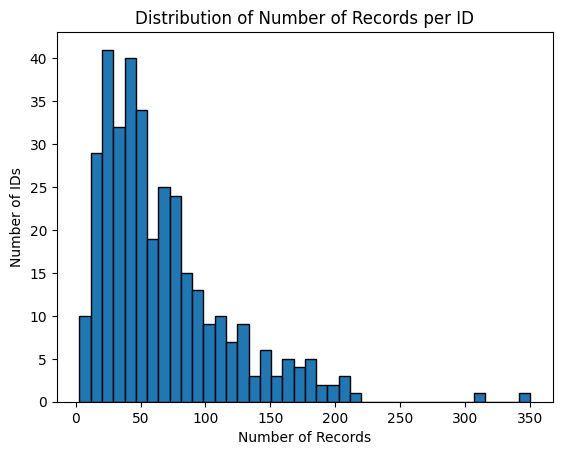

In [21]:
# Calculate the number of records per ID
records_per_id = df['ID'].value_counts()

# Create a histogram
plt.hist(records_per_id, bins=40, edgecolor='black')

# Set the title and labels
plt.title('Distribution of Number of Records per ID')
plt.xlabel('Number of Records')
plt.ylabel('Number of IDs')

# Show the plot
plt.show()

In [22]:
# Group by 'ID' and 'COLLECTED_DATE', and count the number of records in each group
same_day_readings = df.groupby(['ID', 'COLLECTED']).size()

# Find out which IDs had multiple readings on the same day
multiple_same_day_readings = same_day_readings[same_day_readings > 1]

# Print the result
print(multiple_same_day_readings)

ID     COLLECTED          
574    2020-07-14 11:40:00    2
14971  2020-08-11 11:22:00    2
dtype: int64


In [23]:
# Group by 'ID' and find the first 'COLLECTED_DATE' for each group
first_reading_dates = df.groupby('ID')['COLLECTED'].min().reset_index()

# Rename the columns for the join operation
first_reading_dates.columns = ['ID', 'FIRST_READING_DATE']

# Join 'multiple_same_day_readings' with 'first_reading_dates' on 'ID' and 'COLLECTED_DATE'
AU_df = pd.merge(multiple_same_day_readings.reset_index(), first_reading_dates, how='left', left_on=['ID', 'COLLECTED'], right_on=['ID', 'FIRST_READING_DATE'])

# Find out how many of the multiple-reading days were the first day of readings
first_day_multiple_readings = AU_df[AU_df['COLLECTED'] == AU_df['FIRST_READING_DATE']]

# Print the result
print(first_day_multiple_readings)

Empty DataFrame
Columns: [ID, COLLECTED, 0, FIRST_READING_DATE]
Index: []


## 3) Obtain Final Dataframe with the added Kidney Failure Target Variable

In [24]:
df = df_copy

In [25]:
# Create a new column 'Kidney Failure'. If the patient ID is in the list, assign 1, else 0
df['Kidney_Failure'] = df['ID'].isin(patient_ids).astype(int)
df

,COLLECTED,ID,SEX,AGE,INPATIENT/OUTPATIENT,eGFR,Kidney_Failure
1,2019-01-03 12:15:00,2,M,45,OUTPATIENT,23,1
6,2019-01-07 23:05:00,7,M,69,INPATIENT,53,0
9,2019-01-07 23:23:00,10,F,83,INPATIENT,54,0
13,2019-01-07 23:37:00,14,F,65,INPATIENT,48,0
18,2019-01-08 00:10:00,19,M,83,INPATIENT,29,0
...,...,...,...,...,...,...,...
762755,2023-03-31 19:30:00,86286,M,67,INPATIENT,21,0
762763,2023-03-31 20:18:00,7366,M,79,INPATIENT,33,0
762769,2023-03-31 20:33:00,10774,F,56,INPATIENT,85,0
762776,2023-03-31 21:09:00,43998,F,85,INPATIENT,38,0


In [26]:
print("Total number of unique ids:", len(df['ID'].unique()))
print(f"Total number of rows: {len(df)}")
print("Total number of unique ids with KF:", len(df[df['Kidney_Failure']==1]['ID'].unique()))
print(f"Total number of rows with KF: {len(df[df['Kidney_Failure']==1])}")

Total number of unique ids: 10064
Total number of rows: 183600
Total number of unique ids with KF: 353
Total number of rows with KF: 23711


In [27]:
df.sort_values(by=['ID', 'COLLECTED'], inplace=True)
df

,COLLECTED,ID,SEX,AGE,INPATIENT/OUTPATIENT,eGFR,Kidney_Failure
1,2019-01-03 12:15:00,2,M,45,OUTPATIENT,23,1
14749,2019-02-08 00:15:00,2,M,46,INPATIENT,19,1
15622,2019-02-10 00:53:00,2,M,46,INPATIENT,17,1
23341,2019-02-25 16:30:00,2,M,46,OUTPATIENT,15,1
26553,2019-03-04 11:00:00,2,M,46,INPATIENT,15,1
...,...,...,...,...,...,...,...
761690,2023-03-30 04:30:00,149302,M,84,INPATIENT,55,0
762302,2023-03-31 05:30:00,149302,M,84,INPATIENT,50,0
761614,2023-03-29 19:40:00,149311,M,72,INPATIENT,55,0
761836,2023-03-30 07:54:00,149311,M,72,INPATIENT,48,0


In [28]:
# Truncate onwards for each ID where the eGFR first drops below 15.
mask = df.groupby('ID')['eGFR'].transform(lambda x: x.ge(15).cummin())
df = df.loc[mask]
df

,COLLECTED,ID,SEX,AGE,INPATIENT/OUTPATIENT,eGFR,Kidney_Failure
1,2019-01-03 12:15:00,2,M,45,OUTPATIENT,23,1
14749,2019-02-08 00:15:00,2,M,46,INPATIENT,19,1
15622,2019-02-10 00:53:00,2,M,46,INPATIENT,17,1
23341,2019-02-25 16:30:00,2,M,46,OUTPATIENT,15,1
26553,2019-03-04 11:00:00,2,M,46,INPATIENT,15,1
...,...,...,...,...,...,...,...
761690,2023-03-30 04:30:00,149302,M,84,INPATIENT,55,0
762302,2023-03-31 05:30:00,149302,M,84,INPATIENT,50,0
761614,2023-03-29 19:40:00,149311,M,72,INPATIENT,55,0
761836,2023-03-30 07:54:00,149311,M,72,INPATIENT,48,0


In [29]:
AU_df = df

# Convert 'COLLECTED' to datetime and sort the dataframe by 'ID' and 'COLLECTED'
AU_df['COLLECTED'] = pd.to_datetime(AU_df['COLLECTED'])
AU_df.sort_values(['ID', 'COLLECTED'], inplace=True)

# Encode 'SEX' as 2 for female and 1 for male
AU_df['SEX'] = AU_df['SEX'].replace({'F': 2, 'M': 1})

# Drop extraneous columns
AU_df = AU_df.drop(columns=['INPATIENT/OUTPATIENT'])

print("Total number of unique ids:", len(AU_df['ID'].unique()))
print(f"Total number of rows: {len(AU_df)}")
print("Total number of unique ids with KF:", len(AU_df[AU_df['Kidney_Failure']==1]['ID'].unique()))
print(f"Total number of rows with KF: {len(AU_df[AU_df['Kidney_Failure']==1])}")

Total number of unique ids: 10064
Total number of rows: 154516
Total number of unique ids with KF: 353
Total number of rows with KF: 5543


<ipython-input-29-7ecdaf5d53e3>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  AU_df['COLLECTED'] = pd.to_datetime(AU_df['COLLECTED'])
<ipython-input-29-7ecdaf5d53e3>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  AU_df.sort_values(['ID', 'COLLECTED'], inplace=True)
<ipython-input-29-7ecdaf5d53e3>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#return

In [30]:
# Find unique male and female IDs
unique_male_ids = AU_df[AU_df['SEX'] == 1]['ID'].unique()
unique_female_ids = AU_df[AU_df['SEX'] == 2]['ID'].unique()

# Count these unique IDs
male_cases = len(unique_male_ids)
female_cases = len(unique_female_ids)

# Print the counts
print(f"Number of unique male cases: {male_cases}")
print(f"Number of unique female cases: {female_cases}")

Number of unique male cases: 5064
Number of unique female cases: 5000


In [31]:
# Filter out the rows where Kidney_Failure is 1
kidney_failure_df = AU_df[AU_df['Kidney_Failure'] == 1]

# Find unique male and female IDs with kidney failure
unique_male_ids = kidney_failure_df[kidney_failure_df['SEX'] == 1]['ID'].unique()
unique_female_ids = kidney_failure_df[kidney_failure_df['SEX'] == 2]['ID'].unique()

# Count these unique IDs
male_cases = len(unique_male_ids)
female_cases = len(unique_female_ids)

# Print the counts
print(f"Number of unique male cases of kidney failure: {male_cases}")
print(f"Number of unique female cases of kidney failure: {female_cases}")

Number of unique male cases of kidney failure: 216
Number of unique female cases of kidney failure: 137


In [32]:
AU_df.to_csv('/content/drive/MyDrive/CKD/GitHub/data/preprocessed/AU/AU_preprocessed_df.csv', index=False)

# Preprocess Japanese (JP) Data

## 1) Additional Pre-steps

In [33]:
df = pd.read_excel(file_path_JP_raw)

/usr/local/lib/python3.10/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [34]:
df.dtypes

ID                               int64
gender                           int64
age                              int64
SBP                            float64
BMI                            float64
etiology of CKD                  int64
Hb                             float64
Alb                            float64
Cr                             float64
eGFR                           float64
CKD_stage                        int64
CKD category                   float64
dip-stick proteinuria          float64
proteinuria                    float64
urinary occult blood           float64
UPCR                           float64
UPCR category                  float64
hypertension                     int64
prevalence of CVD                int64
diabetes                         int64
use of RAASi                     int64
use of CCB                       int64
use of diuretics                 int64
eGFR(0M)                       float64
50%eGFR                        float64
eGFR(6M)                 

In [35]:
df.isna().sum()

ID                               0
gender                           0
age                              0
SBP                             18
BMI                            137
etiology of CKD                  0
Hb                               2
Alb                             12
Cr                               0
eGFR                             0
CKD_stage                        0
CKD category                    88
dip-stick proteinuria           16
proteinuria                     16
urinary occult blood            16
UPCR                            88
UPCR category                   88
hypertension                     0
prevalence of CVD                0
diabetes                         0
use of RAASi                     0
use of CCB                       0
use of diuretics                 0
eGFR(0M)                         0
50%eGFR                          0
eGFR(6M)                       202
50%eGFR_reached(6M)            202
eGFR(12M)                      332
50%eGFR_reached(12M)

In [36]:
columns_to_flatten = ['eGFR(0M)', 'eGFR(6M)', 'eGFR(12M)', 'eGFR(18M)', 'eGFR(24M)', 'eGFR(30M)', 'eGFR(36M)', 'eGFR(last visit)']

# Use melt to flatten these columns
df_melted = pd.melt(df, id_vars=['ID', 'age', 'gender', 'Cr'], value_vars=columns_to_flatten, var_name='Time', value_name='eGFR')

# Display the melted DataFrame
df_melted

<ipython-input-36-e904686124c7>:4: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resulting Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.
  df_melted = pd.melt(df, id_vars=['ID', 'age', 'gender', 'Cr'], value_vars=columns_to_flatten, var_name='Time', value_name='eGFR')


,ID,age,gender,Cr,Time,eGFR
0,10101,74,2,1.20,eGFR(0M),34.146986
1,10102,39,1,1.31,eGFR(0M),50.451187
2,10103,74,1,4.95,eGFR(0M),9.804696
3,10201,57,1,0.84,eGFR(0M),73.570568
4,10202,32,1,0.87,eGFR(0M),83.558305
...,...,...,...,...,...,...
9099,160109,71,2,1.90,eGFR(last visit),20.901554
9100,160110,62,2,4.74,eGFR(last visit),4.664378
9101,160111,60,1,1.42,eGFR(last visit),41.861876
9102,160112,52,1,2.13,eGFR(last visit),28.931595


In [37]:
df_melted.isna().sum()

ID           0
age          0
gender       0
Cr           0
Time         0
eGFR      2608
dtype: int64

In [38]:
import math

def amend_age(row):
    time_str = row['Time']
    months = 0
    if time_str == 'eGFR(6M)':
        months = 6
    elif time_str == 'eGFR(12M)':
        months = 12
    elif time_str == 'eGFR(18M)':
        months = 18
    elif time_str == 'eGFR(24M)':
        months = 24
    elif time_str == 'eGFR(30M)':
        months = 30
    elif time_str == 'eGFR(36M)':
        months = 36
    elif time_str == 'eGFR(last visit)':
        months = 42  # Adding 42 months for 'last visit'

    amended_age = row['age'] + (months / 12.0)

    # Round down the amended age
    return math.floor(amended_age)

# Apply the function to the DataFrame
df_melted['amended_age'] = df_melted.apply(amend_age, axis=1)
df_melted

,ID,age,gender,Cr,Time,eGFR,amended_age
0,10101,74,2,1.20,eGFR(0M),34.146986,74
1,10102,39,1,1.31,eGFR(0M),50.451187,39
2,10103,74,1,4.95,eGFR(0M),9.804696,74
3,10201,57,1,0.84,eGFR(0M),73.570568,57
4,10202,32,1,0.87,eGFR(0M),83.558305,32
...,...,...,...,...,...,...,...
9099,160109,71,2,1.90,eGFR(last visit),20.901554,74
9100,160110,62,2,4.74,eGFR(last visit),4.664378,65
9101,160111,60,1,1.42,eGFR(last visit),41.861876,63
9102,160112,52,1,2.13,eGFR(last visit),28.931595,55


In [39]:
import numpy as np

# Assuming df_melted is your DataFrame
def calculate_SCr(row):
    age_factor = row['amended_age'] ** -0.287
    gender_factor = 0.739 if row['gender'] == 2 else 1  # assuming 'female' and 'male' are the gender labels
    eGFR = row['eGFR']

    SCr = ((eGFR / (194 * age_factor * gender_factor)) ** (-1 / 1.094))
    return SCr

# Apply the function to create a new column 'Calculated_SCr'
df_melted['Calculated_SCr'] = df_melted.apply(calculate_SCr, axis=1)

# Display the DataFrame to check the results
df_melted

,ID,age,gender,Cr,Time,eGFR,amended_age,Calculated_SCr
0,10101,74,2,1.20,eGFR(0M),34.146986,74,1.200000
1,10102,39,1,1.31,eGFR(0M),50.451187,39,1.310000
2,10103,74,1,4.95,eGFR(0M),9.804696,74,4.950000
3,10201,57,1,0.84,eGFR(0M),73.570568,57,0.840000
4,10202,32,1,0.87,eGFR(0M),83.558305,32,0.870000
...,...,...,...,...,...,...,...,...
9099,160109,71,2,1.90,eGFR(last visit),20.901554,74,1.879483
9100,160110,62,2,4.74,eGFR(last visit),4.664378,65,7.660000
9101,160111,60,1,1.42,eGFR(last visit),41.861876,63,1.370000
9102,160112,52,1,2.13,eGFR(last visit),28.931595,55,1.990000


In [40]:
df_melted['Cr_umol_per_L'] = df_melted['Calculated_SCr'] * 88.4
df_melted

,ID,age,gender,Cr,Time,eGFR,amended_age,Calculated_SCr,Cr_umol_per_L
0,10101,74,2,1.20,eGFR(0M),34.146986,74,1.200000,106.080000
1,10102,39,1,1.31,eGFR(0M),50.451187,39,1.310000,115.804000
2,10103,74,1,4.95,eGFR(0M),9.804696,74,4.950000,437.580000
3,10201,57,1,0.84,eGFR(0M),73.570568,57,0.840000,74.256000
4,10202,32,1,0.87,eGFR(0M),83.558305,32,0.870000,76.908000
...,...,...,...,...,...,...,...,...,...
9099,160109,71,2,1.90,eGFR(last visit),20.901554,74,1.879483,166.146322
9100,160110,62,2,4.74,eGFR(last visit),4.664378,65,7.660000,677.144000
9101,160111,60,1,1.42,eGFR(last visit),41.861876,63,1.370000,121.108000
9102,160112,52,1,2.13,eGFR(last visit),28.931595,55,1.990000,175.916000


In [41]:
# Assuming df_melted is your DataFrame with 'gender', 'age', and 'Cr' columns
def calculate_eGFR_CKD_EPI(row):
    if row['gender'] == 2:
        if row['Cr_umol_per_L'] <= 62:
            return 144 * ((row['Cr_umol_per_L'] * 0.0113 / 0.7) ** -0.329) * ((0.993) ** row['amended_age'])
        else:
            return 144 * ((row['Cr_umol_per_L'] * 0.0113 / 0.7) ** -1.209) * ((0.993) ** row['amended_age'])
    else:  # Assuming gender is male if not female
        if row['Cr_umol_per_L'] <= 80:
            return 141 * ((row['Cr_umol_per_L'] * 0.0113 / 0.9) ** -0.411) * ((0.993) ** row['amended_age'])
        else:
            return 141 * ((row['Cr_umol_per_L'] * 0.0113 / 0.9) ** -1.209) * ((0.993) ** row['amended_age'])

# Apply the function to create a new column 'eGFR_CKD_EPI'
df_melted['eGFR_CKD_EPI'] = df_melted.apply(calculate_eGFR_CKD_EPI, axis=1)

# Display the DataFrame to check the results
df_melted

,ID,age,gender,Cr,Time,eGFR,amended_age,Calculated_SCr,Cr_umol_per_L,eGFR_CKD_EPI
0,10101,74,2,1.20,eGFR(0M),34.146986,74,1.200000,106.080000,44.685607
1,10102,39,1,1.31,eGFR(0M),50.451187,39,1.310000,115.804000,68.187595
2,10103,74,1,4.95,eGFR(0M),9.804696,74,4.950000,437.580000,10.688884
3,10201,57,1,0.84,eGFR(0M),73.570568,57,0.840000,74.256000,97.237557
4,10202,32,1,0.87,eGFR(0M),83.558305,32,0.870000,76.908000,114.245526
...,...,...,...,...,...,...,...,...,...,...
9099,160109,71,2,1.90,eGFR(last visit),20.901554,74,1.879483,166.146322,25.976778
9100,160110,62,2,4.74,eGFR(last visit),4.664378,65,7.660000,677.144000,5.061998
9101,160111,60,1,1.42,eGFR(last visit),41.861876,63,1.370000,121.108000,54.572415
9102,160112,52,1,2.13,eGFR(last visit),28.931595,55,1.990000,175.916000,36.758771


In [42]:
# df_melted = df_melted.drop(['Cr', 'eGFR', 'Calculated_SCr', 'Cr_umol_per_L'], axis =1)
# df_melted

In [43]:
# !pip install missingno

In [44]:
# import missingno as msno

# # Assuming `df` is your pandas DataFrame
# msno.matrix(df_melted)

In [45]:
# import rpy2.robjects.packages as rpackages
# from rpy2.robjects import pandas2ri

# # Utility function to check if an R package is installed
# def is_r_package_installed(package_name):
#     return rpackages.isinstalled(package_name)

# # Function to install an R package
# def install_r_package(package_name):
#     utils = rpackages.importr('utils')
#     utils.chooseCRANmirror(ind=1)  # select the first mirror in the list
#     utils.install_packages(package_name)

# # Check if 'naniar' package is installed; if not, install it
# package_name = 'naniar'
# if not is_r_package_installed(package_name):
#     install_r_package(package_name)

# # Once installed, you can import it and use its functions
# naniar = rpackages.importr('naniar')


In [46]:
# import rpy2.robjects as ro
# from rpy2.robjects import pandas2ri
# import rpy2.robjects.packages as rpackages

# # Activate the pandas to R data frames conversion
# pandas2ri.activate()

# # Install naniar if not already installed
# utils = rpackages.importr('utils')
# if not rpackages.isinstalled("naniar"):
#     utils.install_packages('naniar')

# naniar = rpackages.importr('naniar')

# # Convert your pandas DataFrame to R DataFrame
# r_dataframe = pandas2ri.py2rpy(df_melted)

# # Perform the MCAR test
# mcar_result = naniar.mcar_test(r_dataframe)

# # Print the result
# print(mcar_result)


In [47]:
df_melted.isna().sum()

ID                   0
age                  0
gender               0
Cr                   0
Time                 0
eGFR              2608
amended_age          0
Calculated_SCr    2608
Cr_umol_per_L     2608
eGFR_CKD_EPI      2608
dtype: int64

In [48]:
# Filter the DataFrame to only include rows where 'eGFR_CKD_EPI' is NaN
na_eGFR_CKD_EPI_df = df_melted[df_melted['eGFR_CKD_EPI'].isna()]
na_eGFR_CKD_EPI_df

,ID,age,gender,Cr,Time,eGFR,amended_age,Calculated_SCr,Cr_umol_per_L,eGFR_CKD_EPI
1139,10102,39,1,1.31,eGFR(6M),NaN,39,NaN,NaN,NaN
1150,10210,69,1,6.62,eGFR(6M),NaN,69,NaN,NaN,NaN
1156,10305,78,2,2.20,eGFR(6M),NaN,78,NaN,NaN,NaN
1160,10402,83,1,1.20,eGFR(6M),NaN,83,NaN,NaN,NaN
1176,10420,55,2,4.17,eGFR(6M),NaN,55,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
7956,160104,72,2,3.12,eGFR(36M),NaN,75,NaN,NaN,NaN
7957,160105,63,1,9.35,eGFR(36M),NaN,66,NaN,NaN,NaN
7958,160106,43,1,1.31,eGFR(36M),NaN,46,NaN,NaN,NaN
7961,160109,71,2,1.90,eGFR(36M),NaN,74,NaN,NaN,NaN


In [49]:
len(set(na_eGFR_CKD_EPI_df['ID']))

629

In [50]:
# df_melted['eGFR_CKD_EPI'] = df_melted.groupby('ID')['eGFR_CKD_EPI'].apply(lambda group: group.interpolate(method='linear'))
# df_melted

In [51]:
df_melted.isna().sum()

ID                   0
age                  0
gender               0
Cr                   0
Time                 0
eGFR              2608
amended_age          0
Calculated_SCr    2608
Cr_umol_per_L     2608
eGFR_CKD_EPI      2608
dtype: int64

In [52]:
df_melted.dropna(subset=['eGFR_CKD_EPI'], inplace=True)

In [53]:
# Only Checking Kidney Failure Instances

# Filter the DataFrame to include only rows where eGFR_CKD_EPI is less than 15
filtered_df = df_melted[df_melted['eGFR_CKD_EPI'] < 15]

# Group by gender and count the number of cases
grouped_df = filtered_df.groupby('gender').size()

# Display the count of male and female cases
print("Number of male cases where eGFR_CKD_EPI < 15:", grouped_df.get(1, 0))
print("Number of female cases where eGFR_CKD_EPI < 15:", grouped_df.get(2, 0))

Number of male cases where eGFR_CKD_EPI < 15: 689
Number of female cases where eGFR_CKD_EPI < 15: 394


In [54]:
# Drop the specified columns
df_melted.drop(['age', 'Cr', 'eGFR', 'Calculated_SCr', 'Cr_umol_per_L'], axis=1, inplace=True)
df_melted

,ID,gender,Time,amended_age,eGFR_CKD_EPI
0,10101,2,eGFR(0M),74,44.685607
1,10102,1,eGFR(0M),39,68.187595
2,10103,1,eGFR(0M),74,10.688884
3,10201,1,eGFR(0M),57,97.237557
4,10202,1,eGFR(0M),32,114.245526
...,...,...,...,...,...
9099,160109,2,eGFR(last visit),74,25.976778
9100,160110,2,eGFR(last visit),65,5.061998
9101,160111,1,eGFR(last visit),63,54.572415
9102,160112,1,eGFR(last visit),55,36.758771


In [55]:
# Rename columns
df_melted.rename(columns={
    'amended_age': 'AGE',
    'gender': 'SEX',
    'eGFR_CKD_EPI': 'eGFR'
}, inplace=True)

df_melted

,ID,SEX,Time,AGE,eGFR
0,10101,2,eGFR(0M),74,44.685607
1,10102,1,eGFR(0M),39,68.187595
2,10103,1,eGFR(0M),74,10.688884
3,10201,1,eGFR(0M),57,97.237557
4,10202,1,eGFR(0M),32,114.245526
...,...,...,...,...,...
9099,160109,2,eGFR(last visit),74,25.976778
9100,160110,2,eGFR(last visit),65,5.061998
9101,160111,1,eGFR(last visit),63,54.572415
9102,160112,1,eGFR(last visit),55,36.758771


## 2) Applying Inclusion Criteria

In [56]:
df = df_melted

In [57]:
df.dtypes

ID        int64
SEX       int64
Time     object
AGE       int64
eGFR    float64
dtype: object

In [58]:
print("Total number of unique ids:", len(df['ID'].unique()))

Total number of unique ids: 1138


In [59]:
# Filter in Age 18 and over
df = df[df['AGE'] >= 18]
print("Total number of unique ids:", len(df['ID'].unique()))

Total number of unique ids: 1138


In [60]:
# Sort by date
df.sort_values('ID', inplace=True)

In [61]:
# Filter out patients with less than 3 eGFR measurements
df = df[df.groupby('ID').ID.transform('count') > 2]
print("Total number of unique ids:", len(df['ID'].unique()))

Total number of unique ids: 939


In [62]:
# Assuming df is your DataFrame
time_order = ['eGFR(0M)', 'eGFR(6M)', 'eGFR(12M)', 'eGFR(18M)', 'eGFR(24M)', 'eGFR(30M)', 'eGFR(36M)', 'eGFR(last visit)']
df['Time'] = pd.Categorical(df['Time'], categories=time_order, ordered=True)

# Sort the DataFrame
df = df.sort_values(['ID', 'Time'])
df

,ID,SEX,Time,AGE,eGFR
0,10101,2,eGFR(0M),74,44.685607
1138,10101,2,eGFR(6M),74,33.702778
2276,10101,2,eGFR(12M),75,30.641655
3414,10101,2,eGFR(18M),75,31.129969
4552,10101,2,eGFR(24M),76,26.807906
...,...,...,...,...,...
4550,160112,1,eGFR(18M),53,35.133304
5688,160112,1,eGFR(24M),54,35.502557
6826,160112,1,eGFR(30M),54,33.338440
7964,160112,1,eGFR(36M),55,36.758771


In [63]:
# Filter to only include first readings between 15 (patient in a dialysis) and 59
filter_1 = df.groupby('ID')['eGFR'].apply(lambda x: 15 <= x.iloc[0] <= 59) #logic is same as (first value >=15) and (first value <=59)
df = df[df['ID'].map(filter_1)] # Applying filter
print("Total number of unique ids:", len(df['ID'].unique()))

grouped = df.groupby('ID')['eGFR'].first()
print(grouped)

Total number of unique ids: 597
ID
10101     44.685607
10203     31.094233
10206     45.191558
10208     57.647030
10209     57.791605
            ...    
150403    23.555764
150404    40.630789
160108    30.437540
160111    53.370833
160112    34.579257
Name: eGFR, Length: 597, dtype: float64


In [64]:
print("Total number of unique ids:", len(df['ID'].unique()))

Total number of unique ids: 597


In [65]:
df_copy = df

In [66]:
# Filter the DataFrame to include only rows where eGFR_CKD_EPI is less than 15
filtered_df = df[df['eGFR'] < 15]

# Group by gender and count the number of cases
grouped_df = filtered_df.groupby('SEX').size()

# Display the count of male and female cases
print("Number of male cases where eGFR_CKD_EPI < 15:", grouped_df.get(1, 0))
print("Number of female cases where eGFR_CKD_EPI < 15:", grouped_df.get(2, 0))

Number of male cases where eGFR_CKD_EPI < 15: 369
Number of female cases where eGFR_CKD_EPI < 15: 142


## 3) Kidney Failure Criteria

In [67]:
patient_ids = []

# Loop over unique IDs in the dataframe
for id in df['ID'].unique():

    # Extract records for this patient excluding the first reading (eGFR(0M))
    patient_df = df[(df['ID'] == id) & (df['Time'] != 'eGFR(0M)')]

    # Find instances where eGFR is less than 15
    low_eGFR = patient_df[patient_df['eGFR'] < 15]

    # Check if there are at least two such instances
    if low_eGFR.shape[0] >= 2:
        patient_ids.append(id)

# Print the total number of patients
print(f"Total number of patients: {len(patient_ids)}")

Total number of patients: 162


In [68]:
# Filter the dataframe to only include patients of interest
df = df[df['ID'].isin(patient_ids)]

In [69]:
print("Total number of unique ids:", len(df['ID'].unique()))
print(f"Total number of rows: {len(df)}")

Total number of unique ids: 162
Total number of rows: 983


In [70]:
# Filter the DataFrame to include only rows where eGFR_CKD_EPI is less than 15
filtered_df = df[df['eGFR'] < 15]

# Group by gender and count the number of cases
grouped_df = filtered_df.groupby('SEX').size()

# Display the count of male and female cases
print("Number of male cases where eGFR_CKD_EPI < 15:", grouped_df.get(1, 0))
print("Number of female cases where eGFR_CKD_EPI < 15:", grouped_df.get(2, 0))

Number of male cases where eGFR_CKD_EPI < 15: 365
Number of female cases where eGFR_CKD_EPI < 15: 142


In [71]:
# Sort the DataFrame by the ID column
df_unique = df.drop_duplicates(subset='ID')
sorted_df = df_unique.sort_values('ID')
subset = sorted_df['ID']

### Further Analysis on Patient IDs with Kidney Failure

In [72]:
# Calculate the number of records per ID
records_per_id = df['ID'].value_counts()

# Convert the Series to a DataFrame
records_per_id_df = records_per_id.reset_index()

# Rename the columns
records_per_id_df.columns = ['ID', 'Number of Records']

# Sort DataFrame by 'Number of Records' in descending order
records_per_id_df = records_per_id_df.sort_values(by='Number of Records', ascending=False)

# Display the DataFrame
print(records_per_id_df)

         ID  Number of Records
0     10302                  8
40   150307                  8
29   110213                  8
30   110203                  8
31    90102                  8
..      ...                ...
148   80307                  3
146   20303                  3
145  140108                  3
144   90301                  3
161   80714                  3

[162 rows x 2 columns]


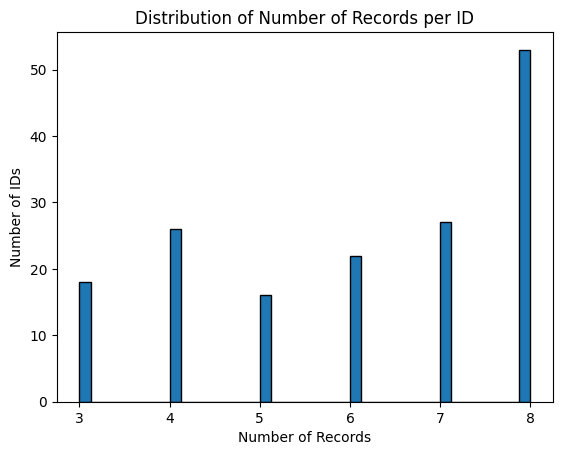

In [73]:
import matplotlib.pyplot as plt

# Calculate the number of records per ID
records_per_id = df['ID'].value_counts()

# Create a histogram
plt.hist(records_per_id, bins=40, edgecolor='black')

# Set the title and labels
plt.title('Distribution of Number of Records per ID')
plt.xlabel('Number of Records')
plt.ylabel('Number of IDs')

# Show the plot
plt.show()

## 4) Obtain Final Dataframe with the added Kidney Failure Target Variable

In [74]:
df = df_copy

In [75]:
# Create a new column 'Kidney Failure'. If the patient ID is in the list, assign 1, else 0
df['Kidney_Failure'] = df['ID'].isin(patient_ids).astype(int)
df

<ipython-input-75-1f82612d3dba>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kidney_Failure'] = df['ID'].isin(patient_ids).astype(int)


,ID,SEX,Time,AGE,eGFR,Kidney_Failure
0,10101,2,eGFR(0M),74,44.685607,0
1138,10101,2,eGFR(6M),74,33.702778,0
2276,10101,2,eGFR(12M),75,30.641655,0
3414,10101,2,eGFR(18M),75,31.129969,0
4552,10101,2,eGFR(24M),76,26.807906,0
...,...,...,...,...,...,...
4550,160112,1,eGFR(18M),53,35.133304,0
5688,160112,1,eGFR(24M),54,35.502557,0
6826,160112,1,eGFR(30M),54,33.338440,0
7964,160112,1,eGFR(36M),55,36.758771,0


In [76]:
print("Total number of unique ids:", len(df['ID'].unique()))
print(f"Total number of rows: {len(df)}")
print("Total number of unique ids with KF:", len(df[df['Kidney_Failure']==1]['ID'].unique()))
print(f"Total number of rows with KF: {len(df[df['Kidney_Failure']==1])}")

Total number of unique ids: 597
Total number of rows: 3930
Total number of unique ids with KF: 162
Total number of rows with KF: 983


In [77]:
# Filter out the rows where Kidney_Failure is 1
kidney_failure_df = df[df['Kidney_Failure'] == 1]

# Find unique male and female IDs with kidney failure
unique_male_ids = kidney_failure_df[kidney_failure_df['SEX'] == 1]['ID'].unique()
unique_female_ids = kidney_failure_df[kidney_failure_df['SEX'] == 2]['ID'].unique()

# Count these unique IDs
male_cases = len(unique_male_ids)
female_cases = len(unique_female_ids)

# Print the counts
print(f"Number of unique male cases of kidney failure: {male_cases}")
print(f"Number of unique female cases of kidney failure: {female_cases}")

Number of unique male cases of kidney failure: 118
Number of unique female cases of kidney failure: 44


In [78]:
#df.sort_values(by=['ID', 'COLLECTED'], inplace=True)
df.isna().sum()

ID                0
SEX               0
Time              0
AGE               0
eGFR              0
Kidney_Failure    0
dtype: int64

In [79]:
# Truncate onwards for each ID where the eGFR first drops below 15.
mask = df.groupby('ID')['eGFR'].transform(lambda x: x.ge(15).cummin())
df = df.loc[mask]
df

,ID,SEX,Time,AGE,eGFR,Kidney_Failure
0,10101,2,eGFR(0M),74,44.685607,0
1138,10101,2,eGFR(6M),74,33.702778,0
2276,10101,2,eGFR(12M),75,30.641655,0
3414,10101,2,eGFR(18M),75,31.129969,0
4552,10101,2,eGFR(24M),76,26.807906,0
...,...,...,...,...,...,...
4550,160112,1,eGFR(18M),53,35.133304,0
5688,160112,1,eGFR(24M),54,35.502557,0
6826,160112,1,eGFR(30M),54,33.338440,0
7964,160112,1,eGFR(36M),55,36.758771,0


In [80]:
JP_df = df.copy()
JP_df

,ID,SEX,Time,AGE,eGFR,Kidney_Failure
0,10101,2,eGFR(0M),74,44.685607,0
1138,10101,2,eGFR(6M),74,33.702778,0
2276,10101,2,eGFR(12M),75,30.641655,0
3414,10101,2,eGFR(18M),75,31.129969,0
4552,10101,2,eGFR(24M),76,26.807906,0
...,...,...,...,...,...,...
4550,160112,1,eGFR(18M),53,35.133304,0
5688,160112,1,eGFR(24M),54,35.502557,0
6826,160112,1,eGFR(30M),54,33.338440,0
7964,160112,1,eGFR(36M),55,36.758771,0


In [81]:
# STATS
print("Total number of unique ids:", len(JP_df['ID'].unique()))
print(f"Total number of rows: {len(JP_df)}")
print("Total number of unique ids with KF:", len(JP_df[JP_df['Kidney_Failure']==1]['ID'].unique()))
print(f"Total number of rows with KF: {len(JP_df[JP_df['Kidney_Failure']==1])}")

Total number of unique ids: 597
Total number of rows: 3388
Total number of unique ids with KF: 162
Total number of rows with KF: 456


In [82]:
# Find unique male and female IDs with kidney failure
unique_male_ids = JP_df[JP_df['SEX'] == 1]['ID'].unique()
unique_female_ids = JP_df[JP_df['SEX'] == 2]['ID'].unique()

# Count these unique IDs
male_cases = len(unique_male_ids)
female_cases = len(unique_female_ids)

# Print the counts
print(f"Number of unique male cases of kidney failure: {male_cases}")
print(f"Number of unique female cases of kidney failure: {female_cases}")

Number of unique male cases of kidney failure: 435
Number of unique female cases of kidney failure: 162


In [83]:
# Filter out the rows where Kidney_Failure is 1
kidney_failure_df = JP_df[JP_df['Kidney_Failure'] == 1]

# Find unique male and female IDs with kidney failure
unique_male_ids = kidney_failure_df[kidney_failure_df['SEX'] == 1]['ID'].unique()
unique_female_ids = kidney_failure_df[kidney_failure_df['SEX'] == 2]['ID'].unique()

# Count these unique IDs
male_cases = len(unique_male_ids)
female_cases = len(unique_female_ids)

# Print the counts
print(f"Number of unique male cases of kidney failure: {male_cases}")
print(f"Number of unique female cases of kidney failure: {female_cases}")

Number of unique male cases of kidney failure: 118
Number of unique female cases of kidney failure: 44


In [84]:
# Export data
JP_df.to_csv('/content/drive/MyDrive/CKD/GitHub/data/preprocessed/JP/JP_preprocessed_df.csv', index=False)